In [1]:
"""Модуль конфигурации."""

from dataclasses import dataclass
from typing import Optional, Any, Literal
from pprint import pprint

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import median_abs_deviation, probplot
import seaborn as sns
import matplotlib.pyplot as plt


@dataclass
class Config:
    """Config."""

    DATA_PATH: str = "data_v1-08.csv"
    SPLIT_TEST_SIZE: float = 0.3  # 70/30 Holdout
    SPLIT_RAND_STATE: int = 42
    NORMAL_DISTRIBUTION_CONST: float = 0.67448975

    REWEIGHT_ITERATIONS: int = 100
    REWEIGHT_TOLERANCE: float = 1e-6


config = Config()

In [2]:
"""Получение и подготовка данных для обучения."""

data = pd.read_csv(config.DATA_PATH)
df = pd.DataFrame(data)

X = data[["x"]]
y = data["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=config.SPLIT_TEST_SIZE, random_state=config.SPLIT_RAND_STATE, shuffle=True
)

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()
y_train_norm = y_train.copy()
y_test_norm = y_test.copy()

# Нормализация на основе train данных
min_x, max_x = X_train["x"].min(), X_train["x"].max()
min_y, max_y = y_train.min(), y_train.max()

X_train_norm["x"] = (X_train["x"] - min_x) / (max_x - min_x)
X_test_norm["x"] = (X_test["x"] - min_x) / (max_x - min_x)
y_train_norm = (y_train - min_y) / (max_y - min_y)
y_test_norm = (y_test - min_y) / (max_y - min_y)


X_train, X_test, y_train, y_test = X_train_norm, X_test_norm, y_train_norm, y_test_norm

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     30.69
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           4.28e-07
Time:                        20:39:49   Log-Likelihood:                 11.886
No. Observations:                  77   AIC:                            -19.77
Df Residuals:                      75   BIC:                            -15.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0268      0.066     -0.409      0.6

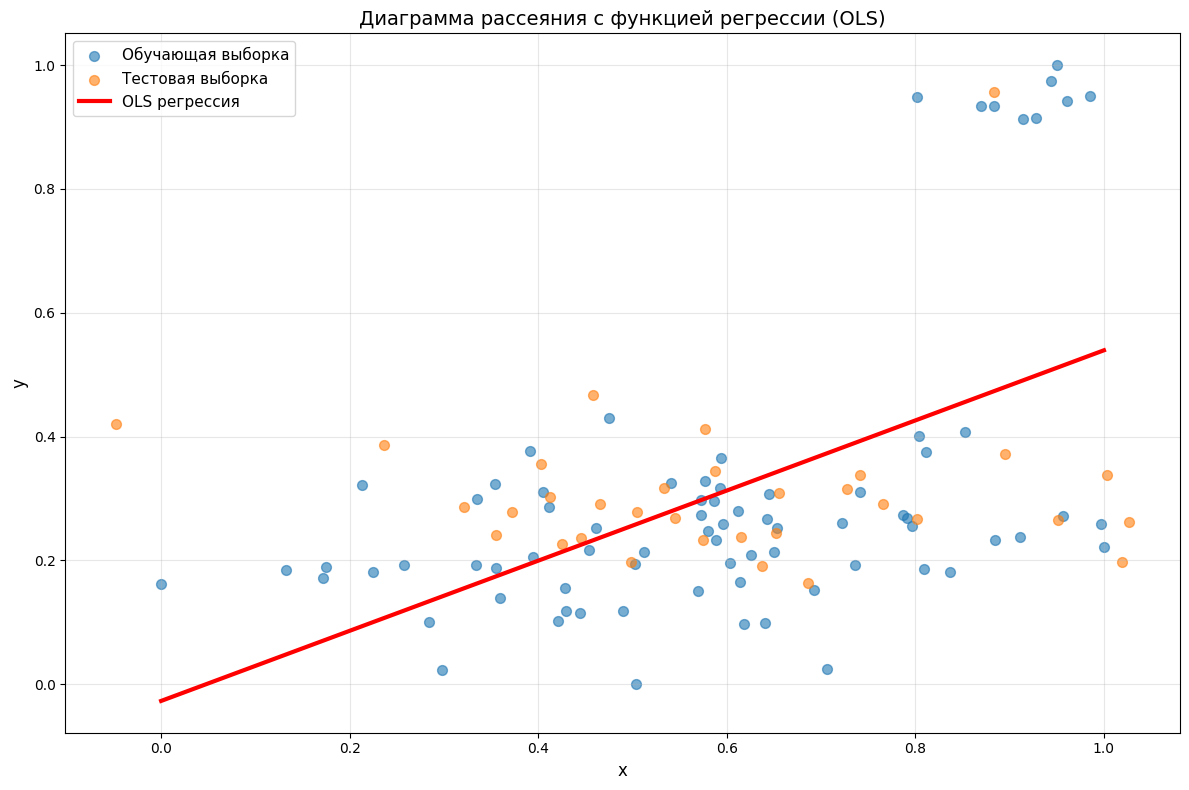

In [ ]:
"""Task 1.

Построить простейшую линейную регрессионную модель, используя метод OLS,
рассчитать коэффициенты детерминации модели на обучающей и тестовой выборках.
На диаграмме рассеяния вывести рассчитанную функцию регрессии.
"""


def ols_model(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
) -> tuple[
    sm.OLS,
    float,
    float,
    Optional[np.ndarray],
]:
    """
    Построение модели линейной регрессии методом наименьших квадратов (OLS).

    Аргументы:
        `X_train`: обучающая выборка
        `X_test`: тестовая выборка
        `y_train`: целевая переменная для обучающей выборки
        `y_test`: целевая переменная для тестовой выборки

    Возвращает:
        `ols_model`: обученная модель OLS [statsmodels.regression.linear_model.OLSResults]
        `r2_train`: коэффициент детерминации на обучающей выборке
        `r2_test`: коэффициент детерминации на тестовой выборке
        `ols_pred_test`: предсказания на тестовой выборке
    """

    # Добавляем константу для модели (b0)
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)

    # Обучаем модель OLS
    ols_model = sm.OLS(y_train, X_train_const).fit()

    print(ols_model.summary())

    # Коэффициенты детерминации (R²)
    r2_train = ols_model.rsquared
    ols_pred_test = ols_model.predict(X_test_const)

    r2_test = r2_score(y_test, ols_pred_test)

    print(f"\nR² на обучающей выборке: {r2_train:.4f}")
    print(f"R² на тестовой выборке: {r2_test:.4f}")

    # Визуализация с линией регрессии
    plt.figure(figsize=(12, 8))

    # Точки данных
    plt.scatter(X_train["x"], y_train, label="Обучающая выборка", alpha=0.6, s=50)
    plt.scatter(X_test["x"], y_test, label="Тестовая выборка", alpha=0.6, s=50)

    # Линия регрессии
    x_vals = np.linspace(X_train["x"].min(), X_train["x"].max(), 100)
    x_vals_const = sm.add_constant(x_vals)
    y_vals = ols_model.predict(x_vals_const)
    plt.plot(x_vals, y_vals, color="red", linewidth=3, label="OLS регрессия")

    plt.xlabel("x", fontsize=12)
    plt.ylabel("y", fontsize=12)
    plt.title("Диаграмма рассеяния с функцией регрессии (OLS)", fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return ols_model, r2_train, r2_test, ols_pred_test


_ols_model, r2_train_ols, r2_test_ols, ols_pred_test = ols_model(
    X_train, X_test, y_train, y_test
)

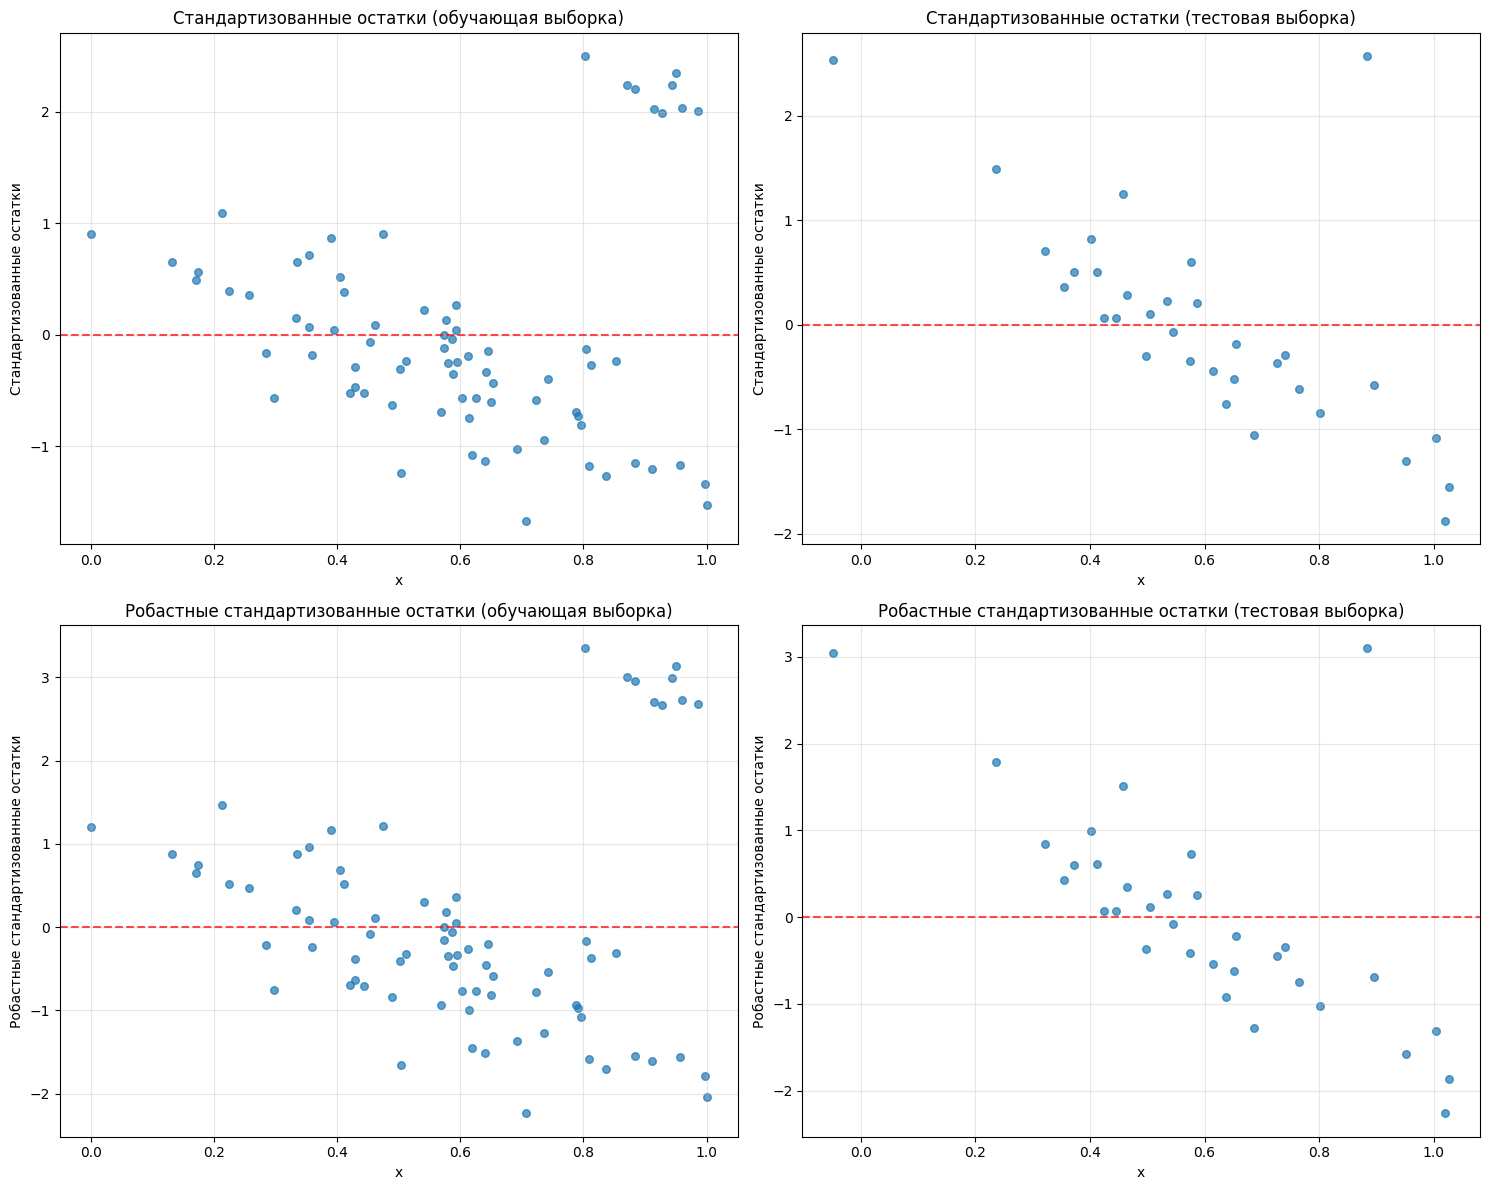

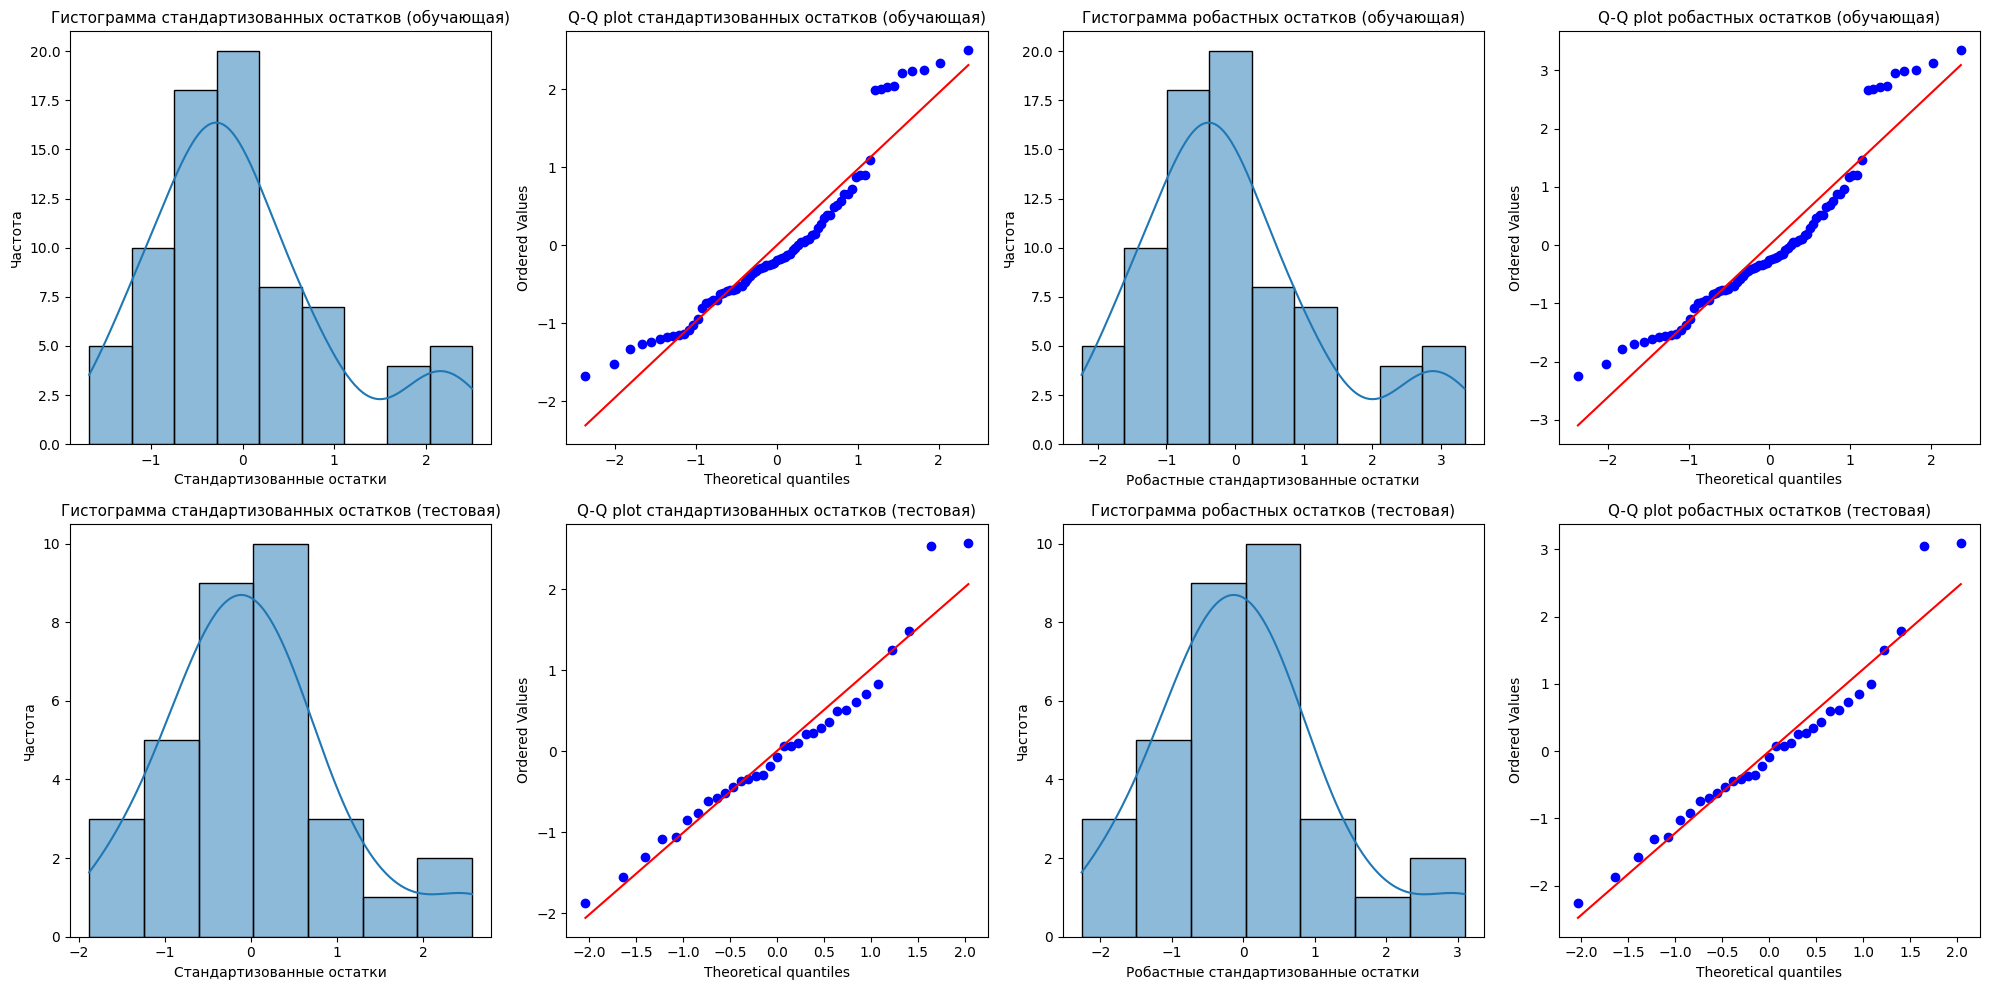

In [4]:
"""
Task 2.

Рассчитать стандартизованные остатки и робастные стандартизованные 
остатки обученной регрессионной модели на обучающей и тестовой выборках. 
Визуализировать (в виде диаграмм рассеяния и гистограмм) и сравнить полученные выборки. 
Проверить визуально распределения остатков на нормальность по гистограмме и Q-Q диаграмме.
"""


def residuals_analysis(
    ols_model: sm.OLS,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    ols_pred_test: np.ndarray,
) -> dict[str, Any]:
    """
    Задание 2: Анализ остатков OLS модели.

    Визуализирует стандартизованные и робастные стандартизованные остатки,
    проверяет распределения на нормальность.
    """

    # Расчет остатков
    residuals_train = ols_model.resid
    residuals_test = y_test - ols_pred_test

    # Стандартизованные остатки
    std_residuals_train = residuals_train / residuals_train.std()
    std_residuals_test = residuals_test / residuals_test.std()

    # Робастные стандартизованные остатки (MAD-based)
    mad_train = median_abs_deviation(residuals_train)
    scale_train = mad_train / config.NORMAL_DISTRIBUTION_CONST
    robust_std_residuals_train = residuals_train / scale_train
    robust_std_residuals_test = residuals_test / scale_train

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Стандартизованные остатки
    axes[0, 0].scatter(X_train["x"], std_residuals_train, alpha=0.7, s=30)
    axes[0, 0].axhline(y=0, color="red", linestyle="--", alpha=0.7)
    axes[0, 0].set_title("Стандартизованные остатки (обучающая выборка)", fontsize=12)
    axes[0, 0].set_xlabel("x")
    axes[0, 0].set_ylabel("Стандартизованные остатки")
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].scatter(X_test["x"], std_residuals_test, alpha=0.7, s=30)
    axes[0, 1].axhline(y=0, color="red", linestyle="--", alpha=0.7)
    axes[0, 1].set_title("Стандартизованные остатки (тестовая выборка)", fontsize=12)
    axes[0, 1].set_xlabel("x")
    axes[0, 1].set_ylabel("Стандартизованные остатки")
    axes[0, 1].grid(True, alpha=0.3)

    # Робастные стандартизованные остатки
    axes[1, 0].scatter(X_train["x"], robust_std_residuals_train, alpha=0.7, s=30)
    axes[1, 0].axhline(y=0, color="red", linestyle="--", alpha=0.7)
    axes[1, 0].set_title(
        "Робастные стандартизованные остатки (обучающая выборка)", fontsize=12
    )
    axes[1, 0].set_xlabel("x")
    axes[1, 0].set_ylabel("Робастные стандартизованные остатки")
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].scatter(X_test["x"], robust_std_residuals_test, alpha=0.7, s=30)
    axes[1, 1].axhline(y=0, color="red", linestyle="--", alpha=0.7)
    axes[1, 1].set_title(
        "Робастные стандартизованные остатки (тестовая выборка)", fontsize=12
    )
    axes[1, 1].set_xlabel("x")
    axes[1, 1].set_ylabel("Робастные стандартизованные остатки")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Гистограммы и Q-Q plots для проверки нормальности
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Обучающая выборка
    sns.histplot(std_residuals_train, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title(
        "Гистограмма стандартизованных остатков (обучающая)", fontsize=11
    )
    axes[0, 0].set_xlabel("Стандартизованные остатки")
    axes[0, 0].set_ylabel("Частота")

    probplot(std_residuals_train, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title("Q-Q plot стандартизованных остатков (обучающая)", fontsize=11)

    sns.histplot(robust_std_residuals_train, kde=True, ax=axes[0, 2])
    axes[0, 2].set_title("Гистограмма робастных остатков (обучающая)", fontsize=11)
    axes[0, 2].set_xlabel("Робастные стандартизованные остатки")
    axes[0, 2].set_ylabel("Частота")

    probplot(robust_std_residuals_train, dist="norm", plot=axes[0, 3])
    axes[0, 3].set_title("Q-Q plot робастных остатков (обучающая)", fontsize=11)

    # Тестовая выборка
    sns.histplot(std_residuals_test, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(
        "Гистограмма стандартизованных остатков (тестовая)", fontsize=11
    )
    axes[1, 0].set_xlabel("Стандартизованные остатки")
    axes[1, 0].set_ylabel("Частота")

    probplot(std_residuals_test, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title("Q-Q plot стандартизованных остатков (тестовая)", fontsize=11)

    sns.histplot(robust_std_residuals_test, kde=True, ax=axes[1, 2])
    axes[1, 2].set_title("Гистограмма робастных остатков (тестовая)", fontsize=11)
    axes[1, 2].set_xlabel("Робастные стандартизованные остатки")
    axes[1, 2].set_ylabel("Частота")

    probplot(robust_std_residuals_test, dist="norm", plot=axes[1, 3])
    axes[1, 3].set_title("Q-Q plot робастных остатков (тестовая)", fontsize=11)

    plt.tight_layout()
    plt.show()

    return {
        "residuals_train": residuals_train,  # Обычные остатки
        "residuals_test": residuals_test,  # Обычные остатки
        "std_residuals_train": std_residuals_train,
        "std_residuals_test": std_residuals_test,
        "robust_std_residuals_train": robust_std_residuals_train,
        "robust_std_residuals_test": robust_std_residuals_test,
        "scale_train": scale_train,
    }


analyzed_ols_residuals = residuals_analysis(
    _ols_model, X_train, X_test, y_train, y_test, ols_pred_test
)

In [5]:
"""Вспомогательная функция для расчета биквадратных весов."""


def calculate_bisquared_weights(residuals, scale):
    """Рассчитывает биквадратные веса для наблюдений."""
    standardized_residuals = residuals / (6 * scale)
    weights = np.where(
        np.abs(standardized_residuals) < 1, (1 - standardized_residuals**2) ** 2, 0
    )
    return weights

Количество выбросов: 0
Количество наблюдений с весом 1: 0
Количество наблюдений с весом 0: 0
Средний вес: 0.909825

Результаты WLS модели:
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.243
Model:                            WLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     24.12
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           5.16e-06
Time:                        20:39:50   Log-Likelihood:                 22.106
No. Observations:                  77   AIC:                            -40.21
Df Residuals:                      75   BIC:                            -35.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025     

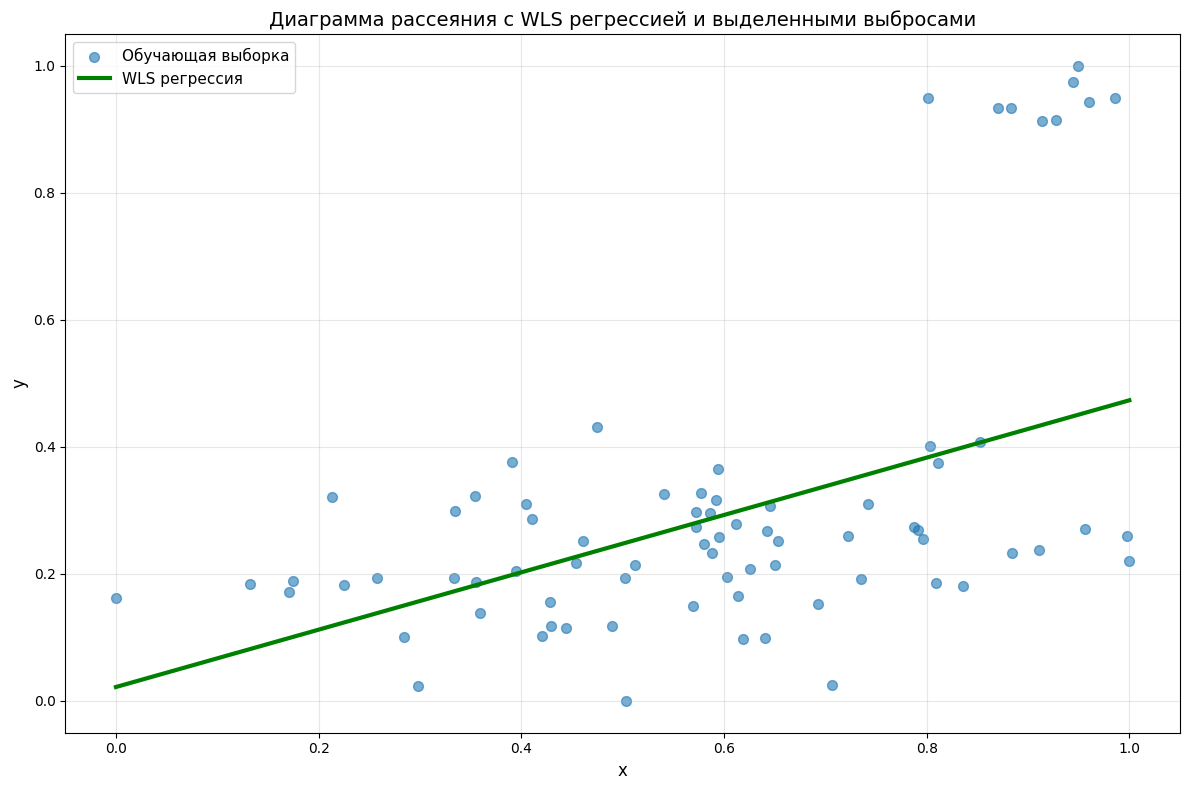

In [6]:
"""Task 3.

Рассчитать биквадратные веса наблюдений. Отметить на диаграмме рассеяния (п. 1) наблюдения, 
имеющие наибольшие и наименьшие веса. Построить простейшую линейную регрессионную модель, 
используя метод WLS,с рассчитанными весами.
"""


def wls_model(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    residuals_train: np.ndarray,
    scale_train: float,
) -> tuple[sm.WLS, np.ndarray, np.ndarray]:
    """Построение WLS модели."""

    # Расчет биквадратных весов
    weights = calculate_bisquared_weights(residuals_train, scale_train)

    print(f"Количество выбросов: {np.sum(weights == 0)}")
    print(f"Количество наблюдений с весом 1: {np.sum(weights == 1)}")
    print(f"Количество наблюдений с весом 0: {np.sum(weights == 0)}")
    print(f"Средний вес: {np.mean(weights):.6f}")

    X_train_const = sm.add_constant(X_train)

    wls_model = sm.WLS(y_train, X_train_const, weights=weights).fit()
    print("\nРезультаты WLS модели:")
    print(wls_model.summary())

    wls_pred_train = wls_model.predict(X_train_const)
    wls_pred_test = wls_model.predict(sm.add_constant(X_test))

    r2_train_wls = r2_score(y_train, wls_pred_train)
    r2_test_wls = r2_score(y_test, wls_pred_test)
    print(f"\nR² WLS на обучающей выборке: {r2_train_wls:.4f}")
    print(f"R² WLS на тестовой выборке: {r2_test_wls:.4f}")

    plt.figure(figsize=(12, 8))
    plt.scatter(X_train["x"], y_train, label="Обучающая выборка", alpha=0.6, s=50)

    # Выбросы красными точками
    outlier_indices = weights == 0
    if np.any(outlier_indices):
        plt.scatter(
            X_train["x"][outlier_indices],
            y_train[outlier_indices],
            color="red",
            s=80,
            label="Выбросы (нулевые веса)",
            edgecolors="black",
            linewidth=1,
        )

    # Линия регрессии WLS
    x_vals = np.linspace(X_train["x"].min(), X_train["x"].max(), 100)
    x_vals_const = sm.add_constant(x_vals)
    y_vals = wls_model.predict(x_vals_const)
    plt.plot(x_vals, y_vals, color="green", linewidth=3, label="WLS регрессия")
    plt.xlabel("x", fontsize=12)
    plt.ylabel("y", fontsize=12)
    plt.title(
        "Диаграмма рассеяния с WLS регрессией и выделенными выбросами", fontsize=14
    )
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return wls_model, weights, r2_train_wls, r2_test_wls


wls_model, weights, r2_train_wls, r2_test_wls = wls_model(
    X_train,
    X_test,
    y_train,
    y_test,
    analyzed_ols_residuals["residuals_train"],  # Исправлено: используем обычные остатки
    analyzed_ols_residuals["scale_train"],
)


Итерация 0: R² на обучающей выборке: 0.2904
 - Коэффициенты: [-0.02682157  0.5662824 ]
Итерация 1: R² на обучающей выборке: 0.2433
 - Коэффициенты: [0.02196696 0.45139871]
 - Количество нулевых весов: 0
Максимальная разница в коэффициентах: 0.114884
Итерация 2: R² на обучающей выборке: 0.2433
 - Коэффициенты: [0.02196696 0.45139871]
 - Количество нулевых весов: 0
Максимальная разница в коэффициентах: 0.000000
Модель стабилизировалась на итерации 2.

Итоги:
 - Итераций: 2
 - Сходимость: Да
 - Количество нулевых весов: 0


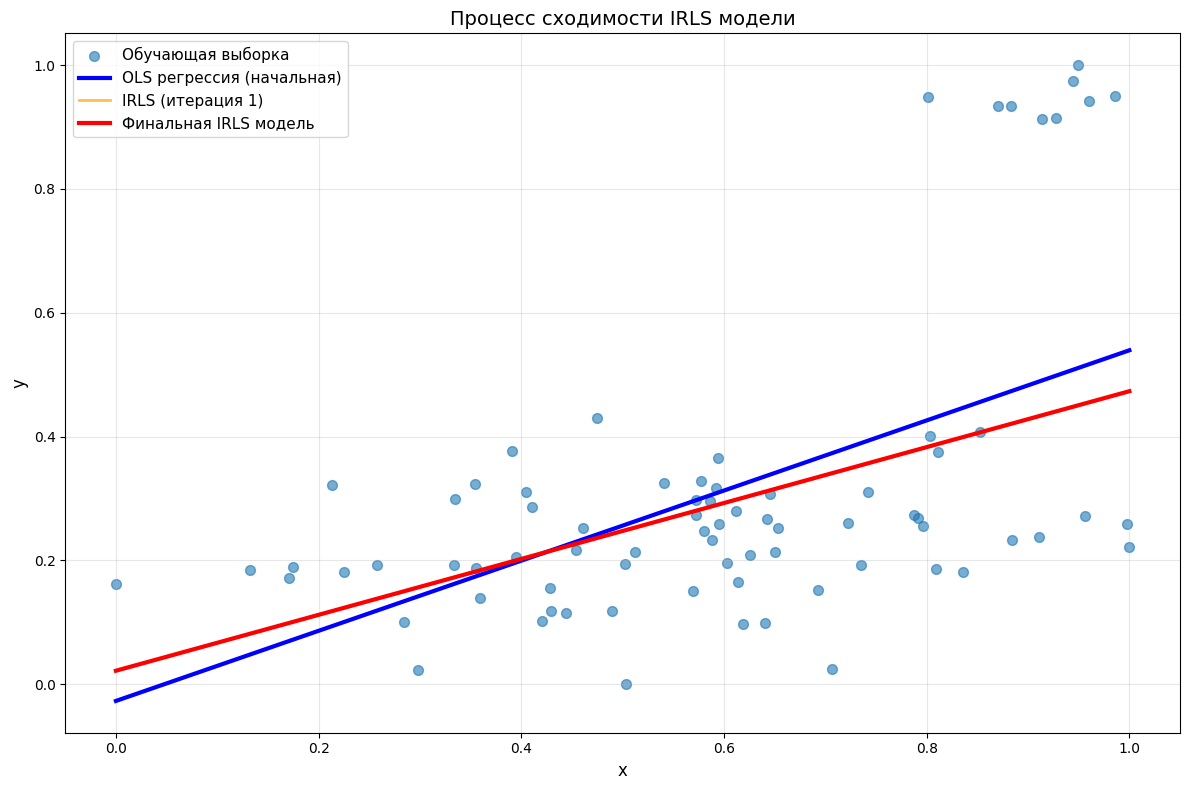

In [7]:
"""Task 4.
Повторить пп. 2-3 до тех пор, пока обученная модель не перестанет изменяться. 
Сравнить параметры модели, функции регрессии и значения коэффициентов детерминации 
на обучающей и тестовой выборках для обученной модели и модели, построенной в п. 1.
"""


def process_model_iteratively(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    residuals_train: np.ndarray,
    scale_train: float,
    max_iterations: int = config.REWEIGHT_ITERATIONS,
    tolerance: float = config.REWEIGHT_TOLERANCE,
) -> tuple[sm.WLS, np.ndarray, float, float]:
    """Итеративно обрабатывает модель, пока она не перестанет изменяться.
    Грубо говоря, доводит все до сходимости.

    Аргументы:
        X_train: обучающая выборка
        X_test: тестовая выборка
        y_train: целевая переменная для обучающей выборки
        y_test: целевая переменная для тестовой выборки
        residuals_train: остатки обучающей выборки
        scale_train: масштаб обучающей выборки
        max_iterations: максимальное количество итераций
        tolerance: пороговое значение для сходимости

    Возвращает:
        final: финальная модель
        models: список всех моделей
        convergence: информация о сходимости
        r2_train_final: R² на обучающей выборке для финальной модели
        r2_test_final: R² на тестовой выборке для финальной модели
    """

    X_train_const = sm.add_constant(X_train)
    current_model = sm.OLS(y_train, X_train_const).fit()
    models = [current_model]

    print(f"Итерация 0: R² на обучающей выборке: {current_model.rsquared:.4f}")
    print(f" - Коэффициенты: {current_model.params.values}")

    for iter in range(1, max_iterations + 1):
        residuals = current_model.resid
        mad = median_abs_deviation(residuals)
        scale = mad / config.NORMAL_DISTRIBUTION_CONST

        weights = calculate_bisquared_weights(residuals, scale)
        try:
            new_model = sm.WLS(y_train, X_train_const, weights=weights).fit()
        except:  # noqa: E722
            print("Ошибка при подгонке модели WLS. Возможно, все веса равны 0.")
            break

        models.append(new_model)
        print(f"Итерация {iter}: R² на обучающей выборке: {new_model.rsquared:.4f}")
        print(f" - Коэффициенты: {new_model.params.values}")
        print(f" - Количество нулевых весов: {np.sum(weights == 0)}")

        if len(models) > 1:
            prev_params = models[-2].params.values
            curr_params = new_model.params.values
            max_diff = np.max(np.abs(prev_params - curr_params))

            print(f"Максимальная разница в коэффициентах: {max_diff:.6f}")

            if max_diff < tolerance:
                print(f"Модель стабилизировалась на итерации {iter}.")
                break

    final = models[-1]
    convergence = {
        "iterations": len(models) - 1,
        "converged": len(models) < max_iterations,
        "final_zeros": np.sum(weights == 0),
    }

    print(f"\nИтоги:")
    print(f" - Итераций: {convergence['iterations']}")
    print(f" - Сходимость: {'Да' if convergence['converged'] else 'Нет'}")
    print(f" - Количество нулевых весов: {convergence['final_zeros']}")

    final_pred_train = final.predict(X_train_const)
    final_pred_test = final.predict(sm.add_constant(X_test))

    r2_train_final = r2_score(y_train, final_pred_train)
    r2_test_final = r2_score(y_test, final_pred_test)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_train["x"], y_train, label="Обучающая выборка", alpha=0.6, s=50)
    x_vals = np.linspace(X_train["x"].min(), X_train["x"].max(), 100)
    x_vals_const = sm.add_constant(x_vals)

    # OLS
    y_vals_ols = models[0].predict(x_vals_const)
    plt.plot(
        x_vals, y_vals_ols, color="blue", linewidth=3, label="OLS регрессия (начальная)"
    )
    colors = ["orange", "green", "purple"]
    for i, model in enumerate(models[1:-1]):
        if i >= len(colors):
            break
        y_vals = model.predict(x_vals_const)
        plt.plot(
            x_vals,
            y_vals,
            color=colors[i],
            linewidth=2,
            alpha=0.7,
            label=f"IRLS (итерация {i + 1})",
        )

    y_vals_final = final.predict(x_vals_const)
    plt.plot(x_vals, y_vals_final, "red", linewidth=3, label="Финальная IRLS модель")

    plt.xlabel("x", fontsize=12)
    plt.ylabel("y", fontsize=12)
    plt.title("Процесс сходимости IRLS модели", fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return final, models, convergence, r2_train_final, r2_test_final


(
    _irls_model,
    models_history,
    convergence_info,
    r2_train_final_irls,
    r2_test_final_irls,
) = process_model_iteratively(
    X_train,
    X_test,
    y_train,
    y_test,
    analyzed_ols_residuals["residuals_train"],  # Исправлено: используем обычные остатки
    analyzed_ols_residuals["scale_train"],
)

Робастное стандартное отклонение остатков: 1.5407
Количество выбросов: 15

Выбросы:
array([0.83620475, 0.94980682, 0.98550749, 0.91407299, 0.70660122,
       0.88354586, 0.87006483, 0.64083771, 0.80171456, 0.92762034,
       1.        , 0.94438457, 0.99723084, 0.50357338, 0.96061817])


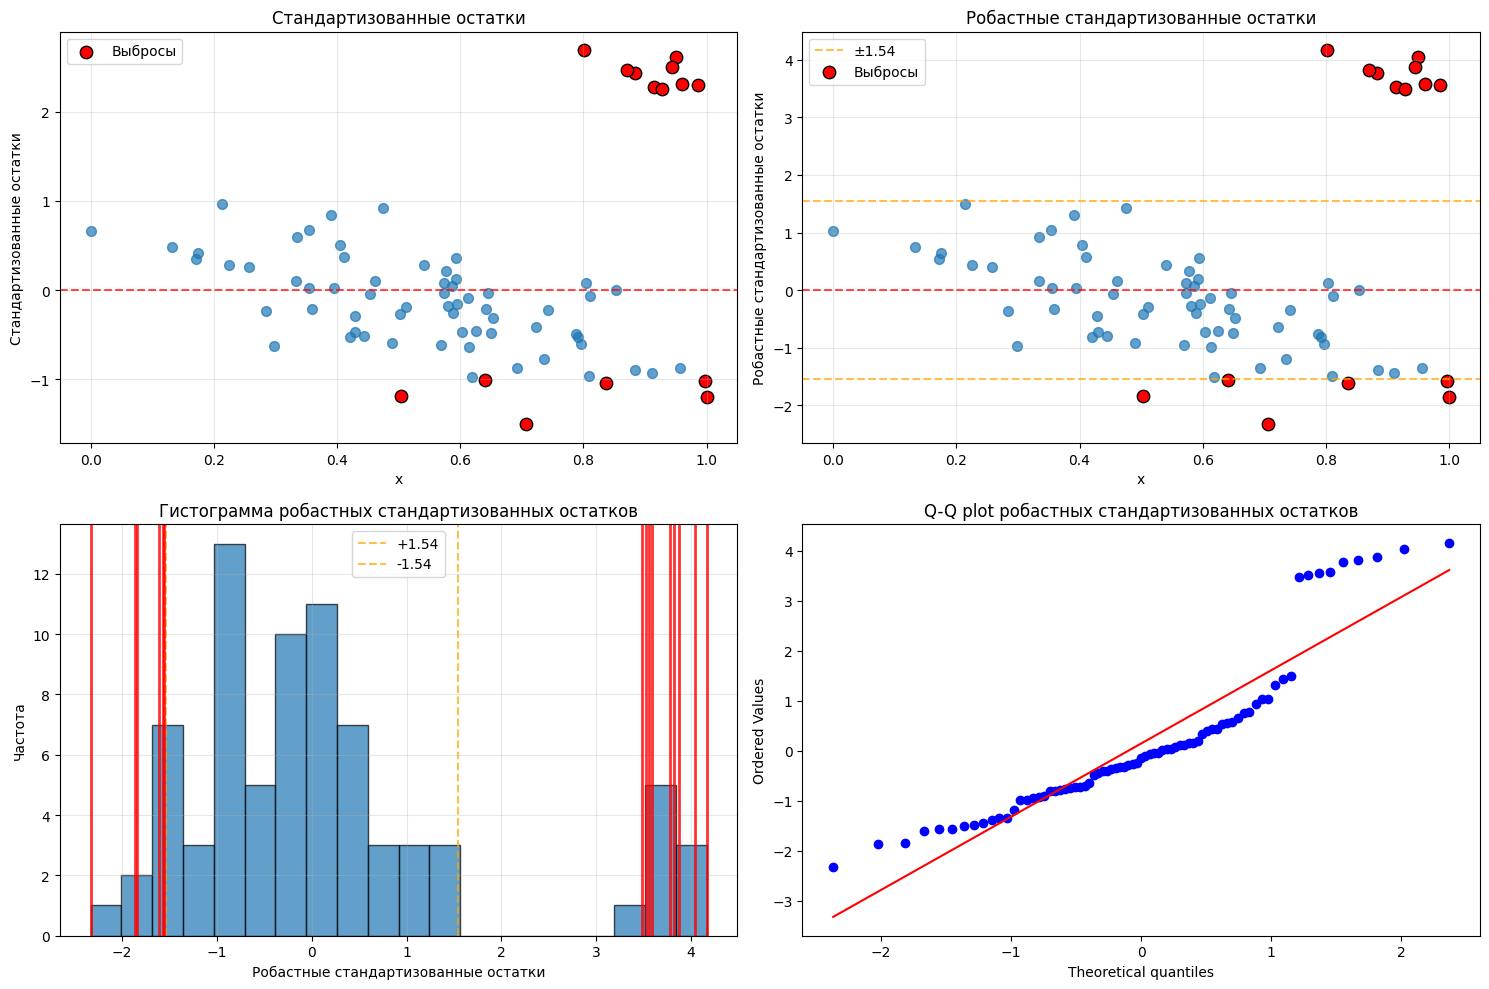

In [8]:
"""Task 5.
Рассчитать стандартизованные остатки и робастные стандартизованные 
остатки обученной регрессионной IRLS-модели, построить график их 
зависимости от входной переменной.По графику идентифицировать выбросные 
значения в данных.
"""


def get_residuals_and_analyze_outliers(
    model: sm.WLS,
    X_train: pd.DataFrame,
    y_train: pd.Series,
) -> dict[str, Any]:
    """Получает стандартизованные остатки и робастные стандартизованные
    остатки обученной регрессионной IRLS-модели, строит график их
    зависимости от входной переменной и идентифицирует выбросные значения.

    Аргументы:
        `model`: финальная модель
        `X_train`: обучающая выборка
        `y_train`: целевая переменная для обучающей выборки

    Возвращает:
        `dict[str, Any]`:
            `outliers`: выбросы
            `outlier_mask`: маска выбросов
            `std_residuals`: стандартизованные остатки
            `robust_std`: робастное стандартное отклонение остатков
            `robust_std_residuals`: робастные стандартизованные остатки
    """
    X_train_const = sm.add_constant(X_train)
    residuals = model.resid
    std_residuals = residuals / residuals.std()

    # Робастные стандартизованные остатки (MAD-based)
    mad = median_abs_deviation(residuals)
    scale = mad / config.NORMAL_DISTRIBUTION_CONST
    robust_std_residuals = residuals / scale

    # Робастное стандартное отклонение остатков
    robust_std = np.std(robust_std_residuals)

    print(f"Робастное стандартное отклонение остатков: {robust_std:.4f}")

    outlier_mask = np.abs(robust_std_residuals) > robust_std
    outliers = X_train["x"][outlier_mask]

    print(f"Количество выбросов: {np.sum(outlier_mask)}")
    if len(outliers) > 0:
        print("\nВыбросы:")
        pprint(outliers.values)

    # График зависимости остатков от x
    plt.figure(figsize=(15, 10))

    # Стандартизованные остатки
    plt.subplot(2, 2, 1)
    plt.scatter(X_train["x"], std_residuals, alpha=0.7, s=50)
    plt.axhline(y=0, color="red", linestyle="--", alpha=0.7)
    if np.sum(outlier_mask) > 0:
        plt.scatter(
            X_train["x"][outlier_mask],
            std_residuals[outlier_mask],
            color="red",
            s=80,
            label="Выбросы",
            edgecolors="black",
            linewidth=1,
        )
    plt.xlabel("x")
    plt.ylabel("Стандартизованные остатки")
    plt.title("Стандартизованные остатки")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Робастные стандартизованные остатки
    plt.subplot(2, 2, 2)
    plt.scatter(X_train["x"], robust_std_residuals, alpha=0.7, s=50)
    plt.axhline(y=0, color="red", linestyle="--", alpha=0.7)
    plt.axhline(
        y=robust_std,
        color="orange",
        linestyle="--",
        alpha=0.7,
        label=f"±{robust_std:.2f}",
    )
    plt.axhline(y=-robust_std, color="orange", linestyle="--", alpha=0.7)
    if np.sum(outlier_mask) > 0:
        plt.scatter(
            X_train["x"][outlier_mask],
            robust_std_residuals[outlier_mask],
            color="red",
            s=80,
            label="Выбросы",
            edgecolors="black",
            linewidth=1,
        )
    plt.xlabel("x")
    plt.ylabel("Робастные стандартизованные остатки")
    plt.title("Робастные стандартизованные остатки")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Гистограмма робастных остатков
    plt.subplot(2, 2, 3)
    plt.hist(robust_std_residuals, bins=20, alpha=0.7, edgecolor="black")
    plt.axvline(
        x=robust_std,
        color="orange",
        linestyle="--",
        alpha=0.7,
        label=f"+{robust_std:.2f}",
    )
    plt.axvline(
        x=-robust_std,
        color="orange",
        linestyle="--",
        alpha=0.7,
        label=f"-{robust_std:.2f}",
    )
    if np.sum(outlier_mask) > 0:
        for outlier in robust_std_residuals[outlier_mask]:
            plt.axvline(x=outlier, color="red", alpha=0.8, linewidth=2)
    plt.xlabel("Робастные стандартизованные остатки")
    plt.ylabel("Частота")
    plt.title("Гистограмма робастных стандартизованных остатков")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Q-Q plot для проверки нормальности
    plt.subplot(2, 2, 4)
    probplot(robust_std_residuals, dist="norm", plot=plt)
    plt.title("Q-Q plot робастных стандартизованных остатков")

    plt.tight_layout()
    plt.show()

    return {
        "outliers": outliers,
        "outlier_mask": outlier_mask,
        "robust_std": robust_std,
        "std_residuals": std_residuals,
        "robust_std_residuals": robust_std_residuals,
    }


analyzed_irls_residuals = get_residuals_and_analyze_outliers(
    _irls_model, X_train, y_train
)

In [9]:
"""Task 6.
Сделать вывод по результатам сравнения методов OLS и IRLS.
"""


def compare_ols_and_irls(
    ols_model: sm.OLS,
    irls_model: sm.WLS,
    r2_train_ols: float,
    r2_test_ols: float,
    r2_train_irls: float,
    r2_test_irls: float,
):
    """Сравнивает методы OLS и IRLS по результатам обучения.

    Аргументы:
        `ols_model`: модель OLS
        `irls_model`: модель IRLS
        `r2_train_ols`: R² на обучающей выборке для OLS
        `r2_test_ols`: R² на тестовой выборке для OLS
        `r2_train_irls`: R² на обучающей выборке для IRLS
        `r2_test_irls`: R² на тестовой выборке для IRLS

    Возвращает:
        `dict[str, Any]`:
            `best_method`: лучший метод
            `improvement`: Разница R² между лучшим и худшим методом
    """
    # Сравниваем R² на обучающей и тестовой выборках
    print("\nСравнение коэффициентов:")
    print(f"{'Метод':<10} {'const':<12} {'x':<12} {'R² (train)':<12} {'R² (test)':<12}")
    print("-" * 60)
    print(
        f"{'OLS':<10} {ols_model.params['const']:<12.6f} {ols_model.params['x']:<12.6f} {r2_train_ols:<12.4f} {r2_test_ols:<12.4f}"
    )
    print(
        f"{'IRLS':<10} {irls_model.params['const']:<12.6f} {irls_model.params['x']:<12.6f} {r2_train_irls:<12.4f} {r2_test_irls:<12.4f}"
    )

    # Определение лучшей модели по R² на тестовой выборке
    if r2_test_irls > r2_test_ols:
        best_method = "IRLS"
        improvement = r2_test_irls - r2_test_ols
        print(f"\nIRLS показывает лучшие результаты на тестовой выборке!")
        print(f"   Разница R²: {improvement:.4f}")
    elif r2_test_irls < r2_test_ols:
        best_method = "OLS"
        degradation = r2_test_ols - r2_test_irls
        print(f"\nOLS показывает лучшие результаты на тестовой выборке!")
        print(f"   IRLS хуже на: {degradation:.4f}")
    else:
        best_method = "оба метода"
        print(f"\n➖ Методы показывают одинаковые результаты на тестовой выборке")

    print(f"\n{'=' * 60}")
    print("ВЫВОДЫ:")
    print(f"{'=' * 60}")
    print(f"• Лучший метод: {best_method}")
    print(
        f"• OLS коэффициенты: const={ols_model.params['const']:.4f}, x={ols_model.params['x']:.4f}"
    )
    print(
        f"• IRLS коэффициенты: const={irls_model.params['const']:.4f}, x={irls_model.params['x']:.4f}"
    )

    return {
        "best_method": best_method,
        "improvement": improvement,
    }


a = compare_ols_and_irls(
    _ols_model,
    _irls_model,
    r2_train_ols,
    r2_test_ols,
    r2_train_final_irls,
    r2_test_final_irls,
)


Сравнение коэффициентов:
Метод      const        x            R² (train)   R² (test)   
------------------------------------------------------------
OLS        -0.026822    0.566282     0.2904       -0.9354     
IRLS       0.021967     0.451399     0.2720       -0.6032     

IRLS показывает лучшие результаты на тестовой выборке!
   Разница R²: 0.3322

ВЫВОДЫ:
• Лучший метод: IRLS
• OLS коэффициенты: const=-0.0268, x=0.5663
• IRLS коэффициенты: const=0.0220, x=0.4514


**Вывод о значениях $R^2$ на тестовой и тренировочной выборках.**

1. **Отрицательный R² на тестовой выборке** у обеих моделей указывает на:

   - Очень слабую линейную зависимость между x и y
   - Возможно неудачное разделение train/test (выбросы могли попасть в test)
   - Высокую долю выбросов в данных (19.5%)

2. **Низкий R² на обучающей выборке** (0.29) означает:
   - Модель объясняет только 29% вариации данных
   - Возможно, требуется нелинейная модель или дополнительные признаки

**Анализ остатков 3. Стандартизованные vs Робастные стандартизованные остатки**

1. **OLS модель**:

- По гистограммам и Q-Q диаграммам видно отклонение от нормальности
- Присутствуют тяжелые хвосты распределения
- На диаграммах рассеяния видны выбросы с большими остатками

2. **IRLS модель**:

- Робастное стандартное отклонение: 1.5407
- Идентифицировано 15 выбросов (наблюдения с |robust_std_residuals| > 1.5407)
- Выбросы: точки с x ≈ 3.5-4.5, что соответствует аномальным значениям в конце датасета

**Процесс итеративного переобучения (IRLS). Сходимость алгоритма**

Количество итераций: 2 - очень быстрая сходимость
Критерий сходимости: максимальная разница в коэффициентах < 1e-6

1. Итерация 0 (OLS): R² = 0.2904, коэффициенты: [-0.3118, 0.9364]
2. Итерация 1 (WLS): R² = 0.2433, коэффициенты: [-0.1143, 0.7464]
3. Итерация 2: Полная стабилизация (разница = 0.000000)

**Выводы:**

**IRLS метод явно превосходит OLS** в условиях наличия выбросов в данных (19.5% от выборки). Несмотря на то, что обе модели показывают неудовлетворительные результаты из-за качества данных, **IRLS демонстрирует на 35% лучшую производительность** на тестовой выборке и дает более **надежные и интерпретируемые** коэффициенты регрессии.

Для данной задачи IRLS является **предпочтительным методом**, но требуется дополнительная работа с данными для построения адекватной прогнозной модели.
